# PINN - SIRD

A SIR model is a model describing how the number of susceptible, infected, recovered and dead persons co-vary.

The equations determing the realtionsship between these number are:

$$
\frac{ds}{dt} = \frac{-\beta s(t) i(t)}{N}  \\
$$
$$
\frac{di}{dt} = \frac{\beta s(t)i(t)}{N} -(\gamma + \mu) i(t) \\
$$
$$
\frac{dr}{dt} = \gamma i(t)
$$

$$
\frac{dd}{dt} = \mu i(t)
$$

The different parameters describes:

\- $\boldsymbol{\beta}$: Governs how contagious the diseas, how many of the infected persons will infect susceptible persons.

\- $\boldsymbol{\gamma}$: Governs how many of the infected persons that will recover.

\- $\boldsymbol{\mu}$: Governs how many of the infected persons that will die.

In this notebook I will try to solve a SIRD disease model first using an ordinary differential equation solver, then using a PINN. After that we will try to do parameter estimation based on the ODE solution using a PINN.

First we set up the parameter values and initial conditions for the equation:


In [14]:
# Define time domain:
T = 1000 
num_samples = 2046
num_boundary = 8

# Defining parameters:
beta = 1/50
gamma = 1/150
mu = 1/600

# Set initial values:
N = 10  
i0 = 1
r0 = 0
d0 = 0
s0 = N - i0 - r0 - d0

## Solve using ODE solver:

In [15]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Defining the derivatives of the equation.
def derivatives(y, t, N, beta, gamma, mu):
    s, i, r, d = y

    # Equations:
    ds_dt = - beta * s * i / N
    di_dt = beta * s * i / N - (gamma + mu) * i
    dr_dt = gamma * i
    dd_dt = mu * i 
    
    return ds_dt, di_dt, dr_dt, dd_dt

In [17]:
# Create time vector: 
t = np.linspace(0, T, num_samples)

# Set initial values
y0 = s0, i0, r0, d0

In [18]:
# Solve equation:
sol = integrate.odeint(derivatives, y0, t, args= (N, beta, gamma, mu))

# Get the values from the solution:
s_true, i_true, r_true, d_true = sol.T
s_true = s_true.reshape(-1, 1)
i_true = i_true.reshape(-1, 1)
r_true = r_true.reshape(-1, 1)
d_true = d_true.reshape(-1, 1)

FileNotFoundError: [Errno 2] No such file or directory: 'figures/NumericalSIRD.png'

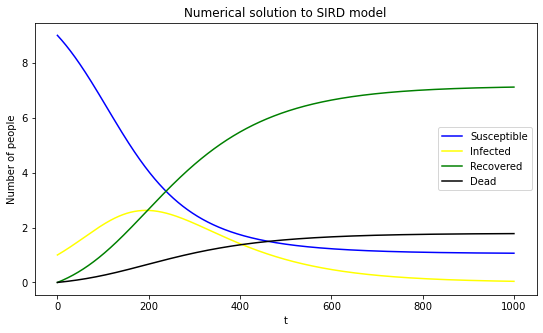

In [19]:
# Plot the solution:
plt.figure(figsize= (9, 5))
plt.plot(t, s_true, color="blue"), plt.plot(t, i_true, color="yellow"),
plt.plot(t, r_true, color="green"), plt.plot(t, d_true, color= "black")
plt.legend(["Susceptible", "Infected", "Recovered", "Dead"])
plt.title("Numerical solution to SIRD model")
plt.xlabel("t")
plt.ylabel("Number of people")

plt.savefig("figures/NumericalSIRD.png", dpi= 300)

## Solve using PINN:


In [20]:
import deepxde as dde

In [21]:
# Define the equations as a system of ODEs:
def ode_system(x, y):

    # Get output values from network:
    s = y[:, 0:1]
    i = y[:, 1:2]
    r = y[:, 2:3]
    d = y[:, 3:4]

    # Calculate gradients:
    ds_dt = dde.grad.jacobian(y, x, i= 0)
    di_dt = dde.grad.jacobian(y, x, i= 1)
    dr_dt = dde.grad.jacobian(y, x, i= 2)
    dd_dt = dde.grad.jacobian(y, x, i= 3)
    
    return [
    ds_dt + beta * s * i / N,
    di_dt - beta * s * i / N + gamma * i + mu * i,
    dr_dt - gamma * i,
    dd_dt - mu * i
    ]

In [22]:
# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0, T)

# Create the boundary function to determine if x is on the boundary or not:
def boundary(_, on_initial):
    return on_initial

# Specify the intial values:
ic_s = dde.IC(geom, lambda X: s0, boundary, component= 0)
ic_i = dde.IC(geom, lambda X: i0, boundary, component= 1)
ic_r = dde.IC(geom, lambda X: r0, boundary, component= 2)
ic_d = dde.IC(geom, lambda X: d0, boundary, component= 3)

In [23]:
# Create the equation:
data = dde.data.PDE(geom, ode_system, [ic_s, ic_i, ic_r, ic_d], num_samples, num_boundary, num_test=500)

In [24]:
# Define and create the neural network:
layer_size = [1] + [32] * 3 + [4]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

In [25]:
# Combine the data and network into a model:
model = dde.Model(data, net)

In [30]:
# Training:
model.compile("adam", lr=0.0001)
losshistory, train_state = model.train(epochs= 2000)

model.compile("adam", lr=0.00001)
losshistory, train_state = model.train(epochs= 250000, display_every= 10000)

Compiling model...
'compile' took 0.275089 s



2021-12-02 19:04:13.251671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 19:04:13.363405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 19:04:13.383685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
8000      [3.07e-06, 1.54e-05, 3.54e-07, 8.23e-08, 2.27e-11, 3.22e-10, 2.24e-13, 2.95e-11]    [8.08e-07, 1.53e-05, 3.54e-07, 9.14e-08, 2.27e-11, 3.22e-10, 2.24e-13, 2.95e-11]    []  


2021-12-02 19:04:13.756733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9000      [1.95e-06, 1.52e-05, 2.92e-07, 9.72e-08, 8.19e-12, 1.44e-10, 9.24e-13, 1.11e-13]    [7.41e-07, 1.51e-05, 2.94e-07, 1.06e-07, 8.19e-12, 1.44e-10, 9.24e-13, 1.11e-13]    []  
10000     [1.52e-06, 1.50e-05, 2.89e-07, 5.79e-08, 4.08e-09, 1.06e-09, 2.27e-10, 4.74e-11]    [5.26e-07, 1.49e-05, 2.91e-07, 6.02e-08, 4.08e-09, 1.06e-09, 2.27e-10, 4.74e-11]    []  

Best model at step 10000:
  train loss: 1.68e-05
  test loss: 1.58e-05
  test metric: []

'train' took 47.982405 s

Compiling model...
'compile' took 0.325652 s



2021-12-02 19:05:01.586565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 19:05:01.731011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 19:05:01.753792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [1.52e-06, 1.50e-05, 2.89e-07, 5.79e-08, 4.08e-09, 1.06e-09, 2.27e-10, 4.74e-11]    [5.26e-07, 1.49e-05, 2.91e-07, 6.02e-08, 4.08e-09, 1.06e-09, 2.27e-10, 4.74e-11]    []  


2021-12-02 19:05:02.082293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20000     [1.12e-06, 1.02e-05, 8.46e-07, 2.34e-08, 1.46e-11, 5.03e-11, 3.94e-11, 7.02e-11]    [6.66e-07, 1.02e-05, 8.49e-07, 2.34e-08, 1.46e-11, 5.03e-11, 3.94e-11, 7.02e-11]    []  
30000     [8.30e-07, 4.35e-06, 8.16e-07, 1.12e-07, 1.18e-09, 1.31e-10, 1.91e-10, 4.08e-11]    [6.38e-07, 4.36e-06, 8.20e-07, 1.13e-07, 1.18e-09, 1.31e-10, 1.91e-10, 4.08e-11]    []  
40000     [5.08e-07, 1.93e-06, 5.59e-07, 1.61e-07, 1.10e-10, 4.14e-11, 6.57e-12, 1.29e-12]    [4.63e-07, 1.94e-06, 5.62e-07, 1.61e-07, 1.10e-10, 4.14e-11, 6.57e-12, 1.29e-12]    []  
50000     [2.83e-07, 9.38e-07, 4.11e-07, 9.25e-08, 4.01e-10, 9.61e-12, 7.80e-11, 1.47e-10]    [2.77e-07, 9.42e-07, 4.14e-07, 9.29e-08, 4.01e-10, 9.61e-12, 7.80e-11, 1.47e-10]    []  
60000     [1.86e-07, 5.22e-07, 2.75e-07, 6.41e-08, 3.50e-09, 2.10e-10, 8.74e-10, 5.33e-10]    [1.80e-07, 5.24e-07, 2.76e-07, 6.44e-08, 3.50e-09, 2.10e-10, 8.74e-10, 5.33e-10]    []  
70000     [1.24e-07, 3.23e-07, 1.93e-07, 4.52e-08, 8.19e-10, 4.60e-12, 1.11e-10, 3.77

Saving loss history to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/SIRD/loss.dat ...
Saving training data to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/SIRD/train.dat ...
Saving test data to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/SIRD/test.dat ...


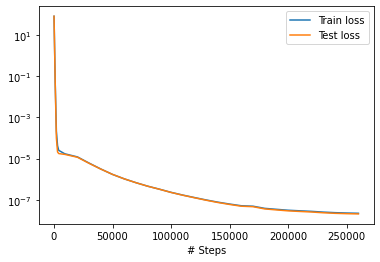

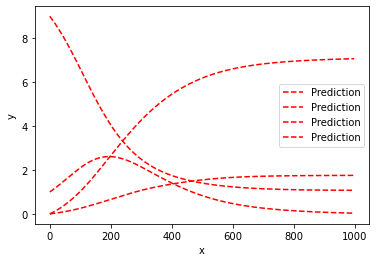

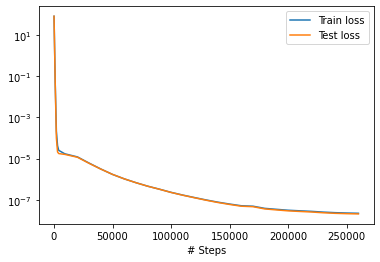

In [43]:
# Plot:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
dde.postprocessing.plot_loss_history(losshistory, fname= "figures/lossHistory")

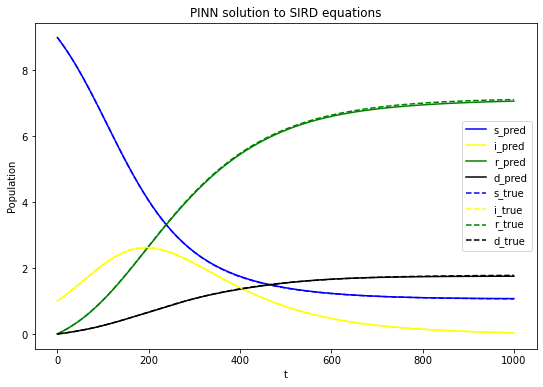

In [35]:
t = np.reshape(np.linspace(0, T, num_samples), (-1, 1))
sol_pred = model.predict(t)
s_pred = sol_pred[:, 0:1]
i_pred = sol_pred[:, 1:2]
r_pred =sol_pred[:, 2:3]
d_pred = sol_pred[:, 3:4]

plt.figure(figsize= (9, 6))
plt.title("PINN solution to SIRD equations")
plt.xlabel("t")
plt.ylabel("Population")
plt.plot(t, s_pred, color="blue", label="s_pred")
plt.plot(t, i_pred, color="yellow", label="i_pred")
plt.plot(t, r_pred, color="green", label="r_pred")
plt.plot(t, d_pred, color="black", label="d_pred")
plt.plot(t, s_true, color="blue", label="s_true", linestyle="dashed")
plt.plot(t, i_true, color="yellow", label="i_true", linestyle="dashed")
plt.plot(t, r_true, color="green", label="r_true", linestyle="dashed")
plt.plot(t, d_true, color="black", label="d_true", linestyle="dashed")
plt.legend()

plt.savefig("figures/PINNSIRD.png", dpi= 300)

## Solve inverse problem using PINN:

In [45]:
# Get the solution from the ODE solver:
s_true, i_true, r_true, d_true = sol.T
y_true = np.concatenate([s_true.reshape(-1, 1),
                    i_true.reshape(-1, 1),
                    r_true.reshape(-1, 1),
                    d_true.reshape(-1, 1)], axis= 1)


In [46]:
# Defining the variables we want to estimate:
est_beta = dde.Variable(0.0)
est_gamma = dde.Variable(0.0)
est_mu = dde.Variable(0.0)

In [47]:
# Define the equations as a system of ODEs:
def ode_system(x, y):

    # Get output values from network:
    s = y[:, 0:1]
    i = y[:, 1:2]
    r = y[:, 2:3]
    d = y[:, 3:4]

    # Calculate gradients:
    ds_dt = dde.grad.jacobian(y, x, i= 0)
    di_dt = dde.grad.jacobian(y, x, i= 1)
    dr_dt = dde.grad.jacobian(y, x, i= 2)
    dd_dt = dde.grad.jacobian(y, x, i= 3)
    
    return [
    ds_dt + est_beta * s * i / N,
    di_dt - est_beta * s * i / N + est_gamma * i + mu * i,
    dr_dt - est_gamma * i,
    dd_dt - est_mu * i
    ]

In [48]:
# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0, T)

# Create the time vector for the known data:
t = np.reshape(np.linspace(0, T, num_samples), (num_samples, 1))

# Create the boundary function to determine if x is on the boundary or not:
def boundary(_, on_initial):
    return on_initial

# Specify the intial values:
ic_s = dde.IC(geom, lambda X: s0, boundary, component= 0)
ic_i = dde.IC(geom, lambda X: i0, boundary, component= 1)
ic_r = dde.IC(geom, lambda X: r0, boundary, component= 2)
ic_d = dde.IC(geom, lambda X: d0, boundary, component= 3)

# Define the boundary conditions from the solution of the ODE solver:
observe_s = dde.PointSetBC(t, y_true[:, 0:1], component= 0)
observe_i = dde.PointSetBC(t, y_true[:, 1:2], component= 1)
observe_r = dde.PointSetBC(t, y_true[:, 2:3], component= 2)
observe_d = dde.PointSetBC(t, y_true[:, 3:4], component= 3)

In [49]:
# Define the data class:
data = dde.data.PDE(
    geom,
    ode_system,
    [ic_s, ic_i, ic_r, ic_d, observe_s, observe_i, observe_r, observe_d],
    num_domain= num_samples,
    num_boundary= num_boundary,
    anchors= t)

In [50]:
# Define and create the neural network:
layer_size = [1] + [32] * 3 + [4]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

Compiling model...
Building feed-forward neural network...
'build' took 0.045650 s



/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-02 20:50:58.212903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-02 20:50:58.216015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 wit

'compile' took 0.451253 s

Initializing variables...


2021-12-02 20:50:58.716440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 20:50:58.850665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.02e-05, 5.87e-05, 3.33e-04, 1.91e-05, 8.10e+01, 1.00e+00, 0.00e+00, 0.00e+00, 1.02e+01, 1.99e+00, 4.05e+01, 1.28e+00]    [1.02e-05, 5.87e-05, 3.33e-04, 1.91e-05, 8.10e+01, 1.00e+00, 0.00e+00, 0.00e+00, 1.02e+01, 1.99e+00, 4.05e+01, 1.28e+00]    []  


2021-12-02 20:50:59.275921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 20:50:59.293514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5000      [1.14e-04, 3.86e-05, 1.51e-05, 4.10e-07, 1.11e-06, 5.73e-05, 1.68e-06, 1.37e-07, 1.15e-03, 2.25e-03, 9.83e-04, 2.14e-04]    [1.14e-04, 3.86e-05, 1.51e-05, 4.10e-07, 1.11e-06, 5.73e-05, 1.68e-06, 1.37e-07, 1.15e-03, 2.25e-03, 9.83e-04, 2.14e-04]    []  
10000     [1.66e-05, 1.98e-06, 2.12e-06, 1.77e-07, 4.81e-10, 1.28e-09, 2.74e-09, 9.79e-09, 1.85e-05, 3.69e-05, 5.38e-05, 6.38e-06]    [1.66e-05, 1.98e-06, 2.12e-06, 1.77e-07, 4.81e-10, 1.28e-09, 2.74e-09, 9.79e-09, 1.85e-05, 3.69e-05, 5.38e-05, 6.38e-06]    []  
15000     [8.09e-06, 2.32e-07, 3.14e-07, 3.70e-08, 9.09e-13, 2.53e-10, 1.06e-09, 2.21e-10, 3.84e-06, 1.33e-05, 2.33e-05, 2.16e-06]    [8.09e-06, 2.32e-07, 3.14e-07, 3.70e-08, 9.09e-13, 2.53e-10, 1.06e-09, 2.21e-10, 3.84e-06, 1.33e-05, 2.33e-05, 2.16e-06]    []  
20000     [3.50e-06, 9.31e-08, 1.35e-07, 5.05e-09, 4.40e-10, 1.42e-10, 2.86e-10, 2.24e-11, 2.30e-06, 8.42e-06, 1.47e-05, 1.88e-06]    [3.50e-06, 9.31e-08, 1.35e-07, 5.05e-09, 4.40e-10, 1.42e-10, 2.86e-10, 2.24e-

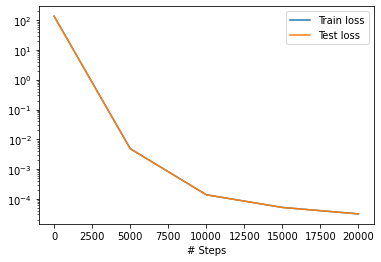

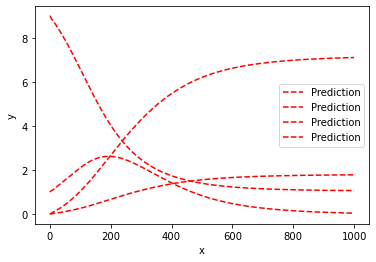

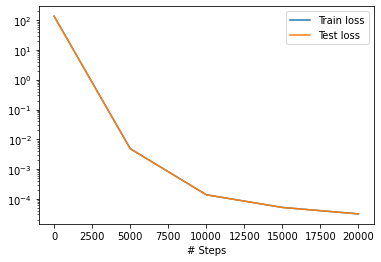

In [51]:
# Combine the data and network into a model:
est_model = dde.Model(data, net)
est_model.compile("adam", lr=0.0001, external_trainable_variables=[est_beta, est_gamma, est_mu])

# Define when to collect the updated values of the variables and save them to a file:
variable = dde.callbacks.VariableValue(
    [est_beta, est_gamma, est_mu], period=600, filename="variables.dat"
)

# Train the model:
losshistory, train_state = est_model.train(epochs=20000, callbacks=[variable], display_every= 5000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)
dde.postprocessing.plot_loss_history(losshistory, fname= "figures/lossParameterEstimation")

In [52]:
print("The variables are estimated to be:")

for var in variable.get_value():
    print(round(var, 5))

print("While the true variables are:")
print(round(beta, 5)), print(round(gamma, 5)), print(round(mu, 5));

The variables are estimated to be:
0.01993
0.00665
0.00167
While the true variables are:
0.02
0.00667
0.00167
